In [3]:
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

In [75]:
# reading the data into a dataframes
# for the simplicity I will assume that the data is in the same folder as the code
df_event_type = pd.read_csv("event_type.csv")
df_log_feature = pd.read_csv("log_feature.csv")
df_resource_type = pd.read_csv("resource_type.csv")
df_severity_type = pd.read_csv("severity_type.csv")
df_train = pd.read_csv("train.csv")

In [5]:
# this small dictionary will allow us to output some basic stats in the loop below
dict_of_df = {"event_type": df_event_type, 
              "log_feature": df_log_feature, 
              "resource_type": df_resource_type, 
              "severity_type": df_severity_type}

In [102]:
# printing basic stats for each dataframe
for df_name, df_temp in dict_of_df.items():
    print("Data: {}, data size: {}, and number of unqie IDs {}".format(df_name, df_temp.shape, len(df_temp["id"].unique())))

Data: event_type, data size: (34082, 2), and number of unqie IDs 18552
Data: log_feature, data size: (58671, 3), and number of unqie IDs 18552
Data: resource_type, data size: (22876, 2), and number of unqie IDs 18552
Data: severity_type, data size: (18552, 2), and number of unqie IDs 18552


In [103]:
df_train.head(2)

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0


In [104]:
df_train["fault_severity"].value_counts()

0    4784
1    1871
2     726
Name: fault_severity, dtype: int64

In [105]:
df_event_type.head(2)

,id,event_type
0,6597,event_type 11
1,8011,event_type 15


In [106]:
# there are 53 event types, in the 2nd or 3rd iteration we may want to combine low frequency categories
df_event_type['event_type'].value_counts()[:5]

event_type 11    9041
event_type 35    6814
event_type 34    6116
event_type 15    5003
event_type 20    1594
Name: event_type, dtype: int64

In [107]:
df_severity_type.head(2)

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2


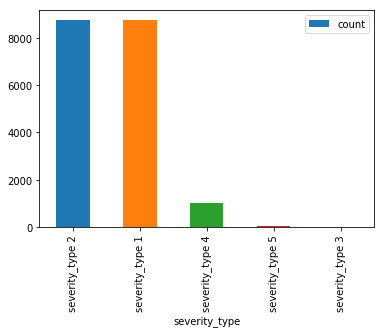

In [108]:
d = df_severity_type['severity_type'].value_counts()
d = pd.DataFrame(d).reset_index()
d.columns = ["severity_type", "count"]
d.plot.bar(x="severity_type", y="count")
plt.show()

In [109]:
df_log_feature.head(2)

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7


In [110]:
# there are 384 features in the log file in its raw format
# many log_features have a single occurance, combining low occurance features (1 and 2 occurances) into other category
d = df_log_feature['log_feature'].value_counts()
d = pd.DataFrame(d).reset_index()
d.columns = ["log_feature", "count"]

In [111]:
np.quantile(d["count"], [0.25, 0.5, 0.75])

array([  7.  ,  24.  , 109.25])

In [112]:
dictLogFeature = dict(zip(d["log_feature"], d["count"]))

In [113]:
# creating a dictionary where I am assigning "feature 001" to the fieatures that only show up 1 or 2 times, all else remains the same
dictLogFeatureReplacement = {}
for k, v in dictLogFeature.items():
    if v > 2:
        dictLogFeatureReplacement[k] = k
    else:
        dictLogFeatureReplacement[k] = "feature 001"

In [114]:
df_log_feature["log_feature"].replace(dictLogFeatureReplacement, inplace=True)

In [115]:
df_resource_type.head(2)

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8


In [116]:
df_resource_type["resource_type"].value_counts()

resource_type 8     11584
resource_type 2      9209
resource_type 6       652
resource_type 7       548
resource_type 4       364
resource_type 9       207
resource_type 3       147
resource_type 10       82
resource_type 1        69
resource_type 5        14
Name: resource_type, dtype: int64

In [117]:
# this will give us each event for each id in one row
df_EventByType = pd.pivot_table(df_event_type, index="id", columns="event_type", fill_value=0, aggfunc=len)
df_EventByType.reset_index(inplace=True)

In [118]:
# for each ID volume per log_feature
df_LogFeature = pd.pivot_table(df_log_feature, index="id", 
                               columns="log_feature", 
                               values="volume", 
                               fill_value=0,
                               aggfunc=np.sum)
df_LogFeature.reset_index(inplace=True)

In [119]:
# this will give us all resource types for each id
df_ResourceType = pd.pivot_table(df_resource_type, index="id", columns="resource_type", fill_value=0, aggfunc=len)
df_ResourceType.reset_index(inplace=True)

In [120]:
# this will give us all severities per id
df_SeverityType = pd.pivot_table(df_severity_type, index="id", columns="severity_type", fill_value=0, aggfunc=len)
df_SeverityType.reset_index(inplace=True)

In [121]:
# building one master dataset by merging the above dataframes with the train dataframe
dfMaster = df_train.merge(df_EventByType, how="left", on="id")
dfMaster = dfMaster.merge(df_LogFeature, how="left", on="id")
dfMaster = dfMaster.merge(df_ResourceType, how="left", on="id")
dfMaster = dfMaster.merge(df_SeverityType, how="left", on="id")

In [122]:
dfMaster.head()

,id,location,fault_severity,event_type 1,event_type 10,event_type 11,event_type 12,event_type 13,event_type 14,event_type 15,...,resource_type 5,resource_type 6,resource_type 7,resource_type 8,resource_type 9,severity_type 1,severity_type 2,severity_type 3,severity_type 4,severity_type 5
0,14121,location 118,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,9320,location 91,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,14394,location 152,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,8218,location 931,1,0,0,2,0,0,0,2,...,0,0,0,2,0,1,0,0,0,0
4,14804,location 120,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [123]:
# creating two objects, the dataframe of predictors and series for the labels
data, labels = dfMaster.iloc[:, 3:], dfMaster.iloc[:, 2]

In [124]:
from sklearn.model_selection import train_test_split

In [125]:
# splitting data into training and testing
data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=0.25, random_state=841)

### Random Forest with grid search

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [127]:
rf = RandomForestClassifier(n_estimators=75)

In [128]:
param_grid = {
    "n_estimators": [125, 175], 
    "criterion": ["gini", "entropy"], 
    "max_depth": [5, 7, 9], 
#     min_samples_split=2, 
#     min_samples_leaf=1, 
#     min_weight_fraction_leaf=0.0, 
    "max_features": ["sqrt", "log2"], 
#     max_leaf_nodes=None, 
#     min_impurity_decrease=0.0, 
#     min_impurity_split=None, 
#     bootstrap=True, 
#     oob_score=False, n_jobs=1, 
#     random_state=None
}

In [41]:
gs = GridSearchCV(rf, param_grid=param_grid, cv=5)

In [42]:
gs.fit(data_train, label_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [125, 175], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 7, 9], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
y_pred = gs.predict(data_test)
confusion_matrix(label_test, y_pred)

array([[1120,   11,   52],
       [ 405,   34,   30],
       [  62,    8,  124]], dtype=int64)

In [49]:
# as we can see below the grid search is not providing the best accuracy
# given more compute power I would experiment more with parameter tuning
accuracy_score(label_test, y_pred)

0.6923076923076923

### A simple Random Forest

In [129]:
rf_ = RandomForestClassifier(n_estimators=125)
rf_.fit(data_train, label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [130]:
y_pred = rf_.predict(data_test)
confusion_matrix(label_test, y_pred)

array([[994, 145,  44],
       [203, 236,  30],
       [ 40,  32, 122]], dtype=int64)

In [131]:
# as we can see results here are slightly better than the RF with grid search
# grid search is leaning toward the first class
accuracy_score(label_test, y_pred)

0.7323943661971831

In [132]:
# data_test["fault_severity"].value_counts()
label_test.value_counts()

0    1183
1     469
2     194
Name: fault_severity, dtype: int64

### Light GBM

In [133]:
from lightgbm import LGBMClassifier

In [61]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'multiclass',
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'multiclass'
         }

gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [75, 150],
    'num_leaves': [7, 10, 15],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'random_state' : [501],
    'colsample_bytree' : [0.6, 0.7],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

lgbm = LGBMClassifier(boosting_type= 'gbdt',
                      objective = params['objective'],
                      silent = True,
                      max_depth = params['max_depth'],
                      max_bin = params['max_bin'],
                      subsample_for_bin = params['subsample_for_bin'],
                      subsample = params['subsample'],
                      subsample_freq = params['subsample_freq'],
                      min_split_gain = params['min_split_gain'],
                      min_child_weight = params['min_child_weight'],
                      min_child_samples = params['min_child_samples'],
                      scale_pos_weight = params['scale_pos_weight']
                     )

In [63]:
grid = GridSearchCV(lgbm, gridParams, verbose=0, cv=4)
grid.fit(data_train, label_train)

In [134]:
lgbmc = LGBMClassifier(n_estimators=125, learning_rate=0.05, num_leaves=25, min_child_samples=10, random_state=599)
lgbmc.fit(data_train, label_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=125, n_jobs=-1, num_leaves=25, objective=None,
        random_state=599, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [135]:
y_pred = lgbmc.predict(data_test)

In [137]:
confusion_matrix(label_test, y_pred)

array([[1047,   73,   63],
       [ 247,  186,   36],
       [  33,   21,  140]], dtype=int64)

In [138]:
accuracy_score(label_test, y_pred)

0.7437703141928494

### KNeighborsClassifier

In [69]:
from sklearn.neighbors import KNeighborsClassifier

In [70]:
knn = KNeighborsClassifier()

In [71]:
search_params = {
                "n_neighbors": [3, 5, 7],
                "leaf_size": [20, 30, 40],
                "p": [1, 2]
}

In [77]:
# I would normally try a grid search, however it is taking too long on my PC
knn.fit(data_train, label_train)
y_pred = knn.predict(data_test)

In [76]:
# knn_grid = GridSearchCV(knn, search_params, verbose=1, cv=5)
# knn_grid.fit(data_train, label_train)
# y_pred = knn_grid.predict(data_test)

In [78]:
confusion_matrix(label_test, y_pred)

array([[1005,  137,   41],
       [ 238,  205,   26],
       [  56,   27,  111]], dtype=int64)

In [79]:
accuracy_score(label_test, y_pred)

0.7156013001083423

### Support Vector Classifier

In [80]:
from sklearn.svm import SVC

In [83]:
svc = SVC(gamma="auto")

In [84]:
svc.fit(data_train, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [85]:
y_pred = knn.predict(data_test)
confusion_matrix(label_test, y_pred)

array([[1005,  137,   41],
       [ 238,  205,   26],
       [  56,   27,  111]], dtype=int64)

In [86]:
accuracy_score(label_test, y_pred)

0.7156013001083423

In [98]:
# will check if scaling the data will provide any improvement
from sklearn.preprocessing import MinMaxScaler

In [99]:
scaler = MinMaxScaler()

In [100]:
data_scaled = scaler.fit_transform(data)

C:\Users\arsha\AppData\Local\conda\conda\envs\sandbox\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [93]:
data_train_scaled, data_test_scaled, label_train_, label_test_ = train_test_split(data_scaled, labels, test_size=0.25, random_state=841)

In [94]:
rf_ = RandomForestClassifier(n_estimators=125)
rf_.fit(data_train_scaled, label_train_)
y_pred = rf_.predict(data_test_scaled)
confusion_matrix(label_test_, y_pred)

array([[1002,  134,   47],
       [ 204,  236,   29],
       [  49,   27,  118]], dtype=int64)

In [95]:
accuracy_score(label_test, y_pred)

0.7345612134344529

In [96]:
svc.fit(data_train_scaled, label_train_)
y_pred = rf_.predict(data_test_scaled)
confusion_matrix(label_test_, y_pred)

array([[1002,  134,   47],
       [ 204,  236,   29],
       [  49,   27,  118]], dtype=int64)

In [97]:
accuracy_score(label_test, y_pred)

0.7345612134344529